# Notebook for Determining Global Variables

__About:__  
The most challenging and most influential step in the data processing is the center finding. Use this notebook to optimize the global variables that are used in both the center finding algorithm including `CENTER_GUESS`, `RADIUS_GUESS`, `DISK_RADIUS`, and `THRESHOLD` and the masking algorithm including `MASK_CENTER`, `MASK_RADIUS`, and `ADDED_MASK`  
  
 __!! Each time you change a global variable, restart your kernel and rerun the following code blocks until you're happy with the result !!__

## Global Variable Usage
The package `gued.py` relies on a few global variables which should be optimized for each experiment. The global variables are stored in `gued_globals.py` and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). 

In [1]:
%%writefile gued_globals.py
### Global Variables for LUED data set
PATH_SEPARATOR = '\\' # input how folders are separator in the file path
# Variable for reading files
SEPARATORS = '_'

# Variables for Center Finding Algorithm
CENTER_GUESS = (465, 475)
RADIUS_GUESS = 35
DISK_RADIUS = 3
THRESHOLD = 0

# Variable for Generating Background
CORNER_RADIUS = 20
CHECK_NUMBER = 50

# Variables for Masking
MASK_CENTER = [525, 515]
MASK_RADIUS = 50
#ADDED_MASK = [[546, 470, 40]]
ADDED_MASK = []

# Used throughout code as the threshold for cutting out date. This is the default value but other values can be set for the functions using this variable
STD_FACTOR = 3

# Specifies the maximum number of workers to be used when running concurrent.futures
MAX_PROCESSORS = 6

# Adjust figure size 
FIGSIZE = (12,4)

# Path for Theory Package
PATH_DCS = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\Coding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'



Overwriting gued_globals.py


## Import Packages

In [2]:
# Standard Packages
import numpy as np
import glob
import matplotlib.pyplot as plt
import random


# new code 
import gued

#interactive plotting 
%matplotlib widget

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [3]:
#data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180823\\Run\\*\\'
data_path = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\LUED_Data\\20240829_0638\\"
run_path = "*\\ANDOR1_*.tif"

full_path = data_path + run_path
#full_path = "D:\\UED_Data\\CP Images\\ANDOR1_*.tif"
print(full_path)

files = glob.glob(full_path) 

print(len(files))


C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\LUED_Data\20240829_0638\*\ANDOR1_*.tif
0


### Reading in All Data and Getting Total Counts

In [4]:
help(gued.get_image_details)

Help on function get_image_details in module gued:

get_image_details(file_names, sort=True, filter_data=False, plot=False)
    Reads all images from input file_names and returns the data as a 3d array along with stage positions, order, and counts per image.
    
    ARGUMENTS:
    
    file_names (list):
        list of file names to be read in
    
    OPTIONAL ARGUMENTS:
    
    sort (boolean): 
        default is set to True. This arguments sorts the data based on when it was saved (i.e. file number)
    plot (boolean): 
        default is set to False. When True, a plot of the data, log(data), and histogram of counts is shown
    filter_data (boolean or list): 
        default is set to False. If you want to select only a fraction of the images, set filter_data = [min_image,]
    
    GLOBAL VARIABLES:
    
    SEPARATORS (list):
        list of strings such as '_' or '-' which are used in the file naming scheme to separate values needed for data analysis (i.e. stage
        posi

Takes ~ 30 seconds for 2000 images

Loading diffraction signal


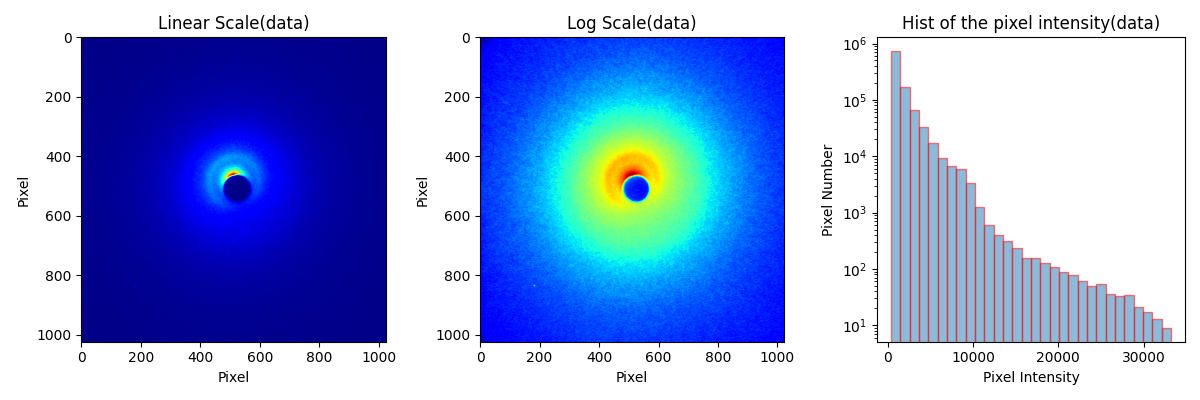

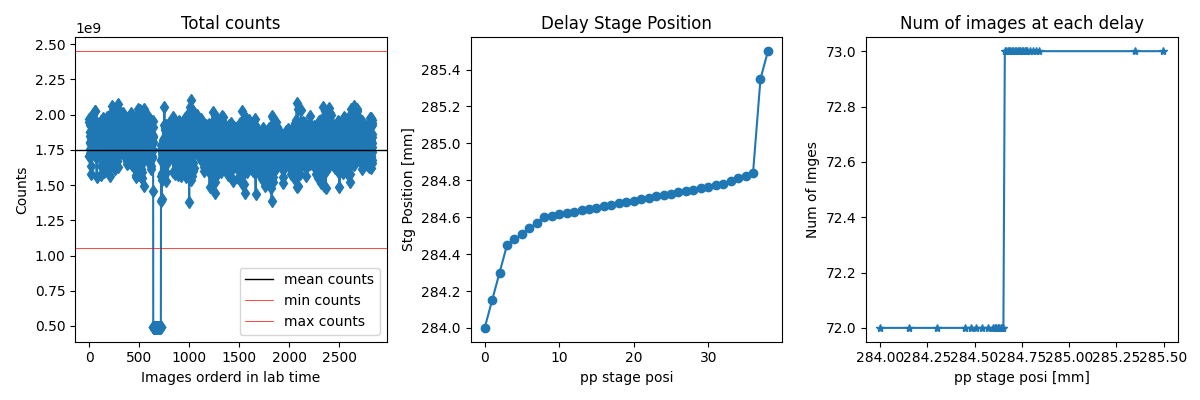

In [5]:
print('Loading diffraction signal')
data_array, stage_positions, file_numbers, counts = gued.get_image_details(files[:], sort=True, filter_data=False, plot=True)


## Remove Images with Bad Counts

In [6]:
help(gued.remove_counts)

Help on function remove_counts in module gued:

remove_counts(data_array, stage_positions, file_order, counts, added_range=[], std_factor=3, plot=False)
    Filters input parameters by removing any data where the total counts falls outside of the set filter. Default
    value is set to 3 standard deviations from the mean. Returns the same variables as it inputs but with
    different dimensions.
    
    ARGUMENTS:
    
    data_array (ndarray): 
        Multidimensional array of N x 1024 x 1024 where N is the length of file_names list
    stage_pos (array): 
        One dimensional array of length N containing the stage positions associated with each image.
    file_order (array): 
        One dimensional array of length N that reflects the order with which the images are taken.
    counts(ndarray): 
        One dimensional array of length N containing the total counts after summing over each array
        element.
    
    OPTIONAL ARGUMENTS:
    
    std_factor (int): 
        Defau

77  number of files removed from  2831  initial files


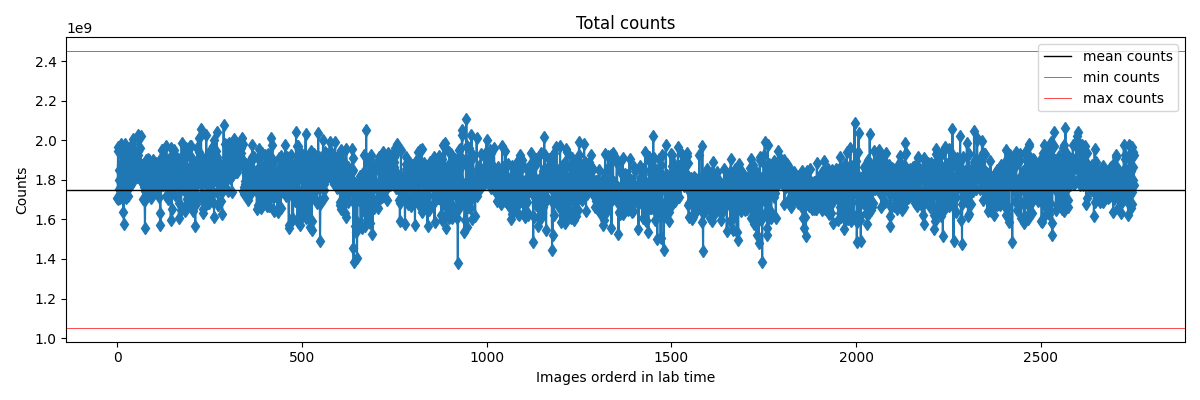

In [7]:
# Remove Outlier Images Based on Total Counts
data_array, stage_positions, file_numbers, counts = gued.remove_counts(data_array, stage_positions, file_numbers, counts, added_range=[], plot=True)


## Create Test Set of Images and process

Need to do these steps so that variables can be used in the fast analysis notebook

In [8]:
file_numbers = list(range(len(data_array)))
rand_idx = random.sample(file_numbers, 50) 
print(np.array(rand_idx))
data_array = data_array[rand_idx]
print("Removing background")
data_array = gued.remove_background_pool(data_array)
print("Removing xrays")
data_array = gued.remove_xrays_pool(data_array, plot=False)

[2565 2224  662 1771  498  913 2711 1241 1884 2243 2734 1322 1783 2505
  503 2234 1272  153 2551 2328 1488 2673 2238  796 2659 1468  199 2708
  173 2161  548 2609  720 2162 1595  147 1093  955 2042  499 2160 1192
  568  422 2237  692  712 2506    5 2151]
Removing background
Removing xrays
Removing hot pixels from all data


## Find Areas to Mask

In [9]:
help(gued.apply_mask) # for one image, used this function

Help on function apply_mask in module gued:

apply_mask(data_array, fill_value=nan, add_rectangular=False, plot=False, print_vals=False)
    Applies a mask to individual images in the data array.
    
    ARGUMENTS:
    
    data_array (array):
        2D or 3D array of an image or images.
    
    OPTIONAL ARUGMENTS:
    
    fill_value (int, float, or nan):
        Default set to np.nan. Value used to fill the area of the mask.
    add_rectangular (boolean)
        The default is True. Adds an additional mask with rectangular shape. 
    plot (boolean):
        Default set to False. When true, plots a figure with the original data, the masked data, and a contour map of the data
    print_vals (boolean):
        Default set to False. When true, prints the values at each contour line. Useful for setting global variables
    
    GLOBAL VARIABLES:
    
    MASK_CENTER : 1D array, tuple, or list that contains only two values
        Center for generating mask cover unscattered electron b

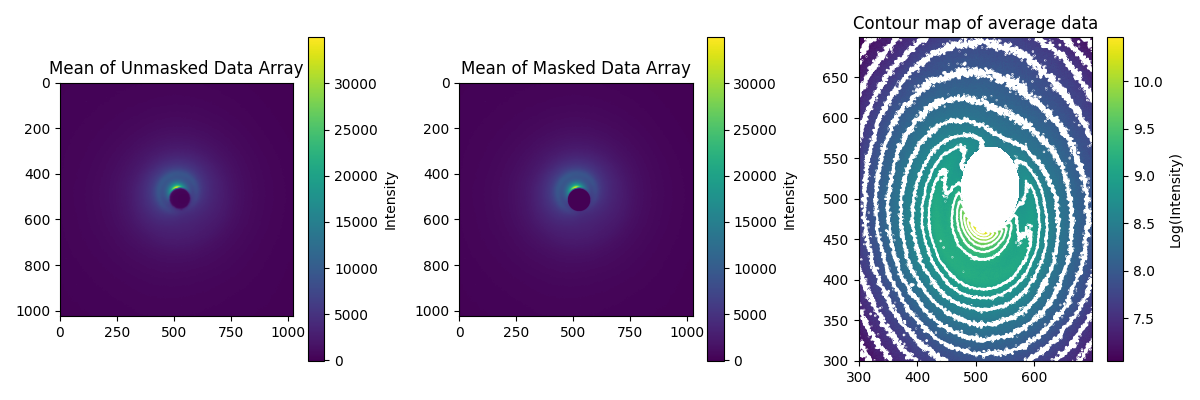

In [10]:
data_array = gued.apply_mask(data_array, fill_value=0.0, plot=True)

## Finding Diffraction Center

In [11]:
help(gued.finding_center_alg) # for one image use this function

Help on function finding_center_alg in module gued:

finding_center_alg(image, plot=False, title='Reference Image')
    Algorithm for finding the center of diffraction pattern
    
    ARGUMENTS:
    
    data_array : 2D array
        Diffraction pattern.
    
    OPTIONAL ARGUMENTS:
    
    thresh_input (float):
        Default set to 0. When zero, the threshold value is calculated using threshold_otsu from scikit-images. Often doesn't work
    plot : boolean, optional
        Show figure of the result of center finding. The default is False.
    title : str, optional
        Title of the figure. The default is 'Reference image'.
    
    
    GLOBAL VARIABLES:
    
    DISK_RADIUS : int, optional
        Generates a flat, disk-shaped footprint. The default is 3.
    CENTER_GUESS : tuple contains 2 values, optional
        Guessing center position to generate temporary mask. The default is (532, 520).
    RADIUS_GUESS : int, optional
        Guessing radius of the temporary mask. The

### Find Average Center

Adjust the `THRESHOLD` value then update the `gued_globals.py` file and restart code

In [12]:
# First, check the threshold value being calculated by the code, a good value is usually close to 100
from skimage.filters import threshold_otsu
for data in data_array:
    print(threshold_otsu(data))

3177.2476896467842
3219.7899108487436
3051.120534589358
2872.798184447045
2774.175507151736
3357.4119604735806
3288.1336378838914
3358.452697081994
3143.3180223695645
3454.461340470648
3276.9745307454023
3226.1299024099562
2754.4269020521547
3774.8795061060605
3263.578412603498
3277.1659759239164
3232.400237726803
3613.023107135
3388.9848738187625
4054.041572249305
3341.289742565093
3431.7939952811703
3466.224893795715
3139.9123491901655
3191.44086257415
3486.993427950043
3052.4411376839043
3350.5405324744193
2739.401997717905
3149.6967466189035
3043.368683191613
3736.839598942928
3132.7506583673476
3116.6231758830486
2927.229555748115
3356.192397312162
3027.4090948962667
3081.205534785076
3047.554328207384
3184.126786382713
3498.6950852662403
3211.339945554524
3300.4875450297195
3286.5232991906123
3037.6499826175386
3131.096914042092
3339.0054495150002
3055.2285983468973
3057.19258679935
3463.449861884081


In the left most graph below, you want the yellow to look circular at the smallest radius possible so adjust `THRESHOLD` value to minimize radius values and minimize range of found center values

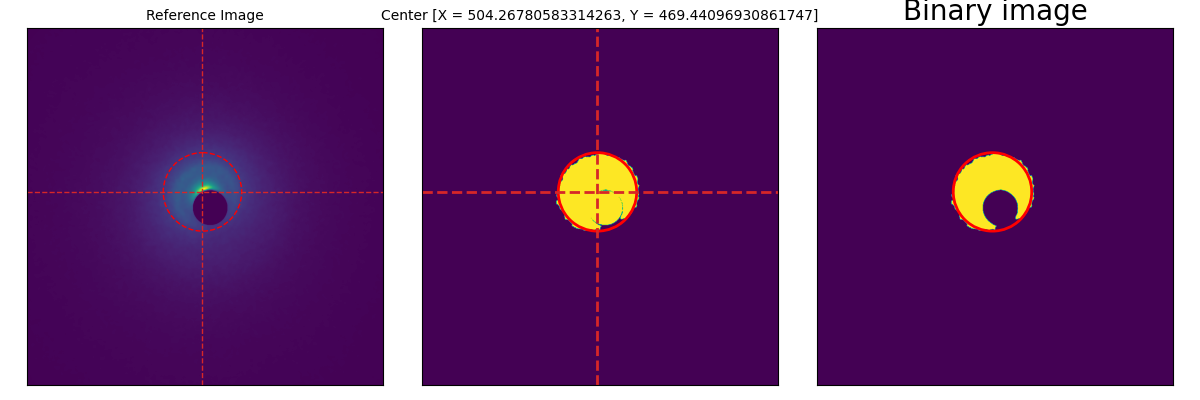

504.26780583314263 469.44096930861747


In [13]:
center_x, center_y, _, _ = gued.finding_center_alg(data_array[0], plot=True)
print(center_x, center_y)

### Find all centers 

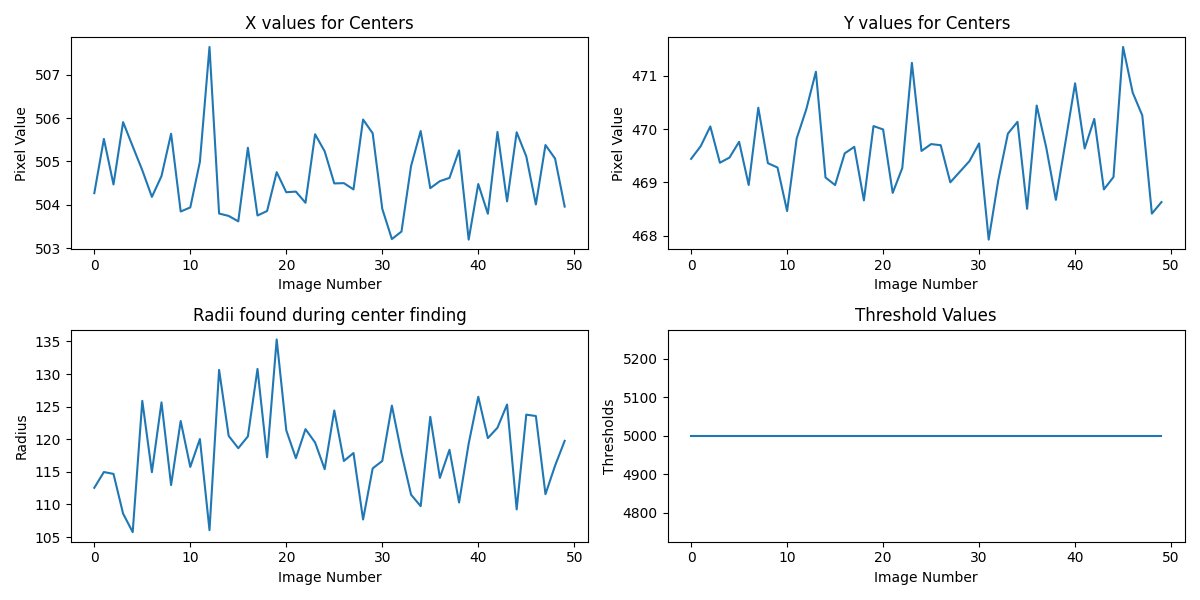

In [14]:
center_x, center_y = gued.find_center_pool(data_array, plot=True)

Now you can run the `Fast_Analysis.ipynb` notebook with the optimized global variables. 